In [1]:
import os
import glob
import datetime
import numpy as np
from astropy.io import fits
from photutils import DAOStarFinder, CircularAperture
import photutils.psf
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.signal import peak_widths
import astropy.units as u
import pandas as pd
from scipy import stats
from calibFuncs import * #sortData, starLocate, nircEPSF, calcBinDist

In [2]:
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\nirc2-trapezium'
NIRC2_datasets = sortData(datadir, instrument='NIRC2', filesufx='*.fit*')

  2%|█▋                                                                                | 3/145 [00:00<00:05, 27.78it/s]

sorting individual images


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

sorting unique datasets into lists


In [ ]:
uniques = sortData(datadir, instrument='NIRC2', filesufx='*.fit*', returntab=True)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(9,9))
ax = plt.gca()

data, head = fits.getdata(NIRC2_datasets[14][3], header=True)
data = high_pass_filter(data, filtersize=(data.shape[0]/16))
wave = head['FWONAME']
if wave == 'Br_gamma':
    wave = 'Br$\gamma$'

im = ax.imshow(data, norm=ImageNormalize(stretch=AsinhStretch(a=0.05), vmin=0, vmax=2000), origin='lower')
ax.set_xlim(0,250)
ax.set_ylim(250,500)
plt.annotate(xy=[80,340], s='B1+B5', c='cyan', size=15, weight='bold')
plt.annotate(xy=[140,410], s='B4', c='cyan', size=15, weight='bold')
plt.annotate(xy=[180,360], s='B2', c='cyan', size=15, weight='bold')
plt.annotate(xy=[205,315], s='B3', c='cyan', size=15, weight='bold')
plt.title(r'$\theta^1$ Orionis B, Keck/NIRC2 '+wave+' Highpass Filtered', size=20)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.savefig('tet1oriB_NIRC2_highpass.png', dpi=150, transparent=True)


In [5]:
len(NIRC2_datasets)
# vert ang datasets: [5,6,7,10]

16

7
rotator mode was set to: position angle
NA offset applied will be: -0.952
Choose a reference star image to create a reference PSF from


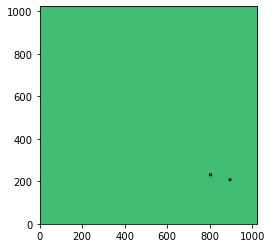

    xcentroid         ycentroid           roundness     
----------------- ------------------ -------------------
895.7480217416636 207.05264858773754 0.08021596257921941
803.6705975079796  230.3206039723621 0.08997687766926604


input the 0 indexed integer of your target from the table above:  1


target star is at  803 , 230  at FWHM 4.860311794531981


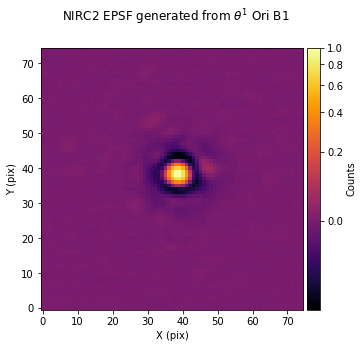

Select your target system to fit positions to


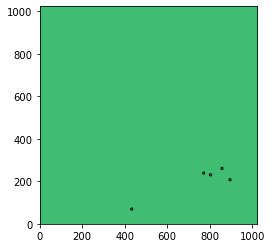

    xcentroid          ycentroid           roundness     
------------------ ------------------ -------------------
433.05899502862457  69.10101185161561 0.07587514853260735
 895.7480217416636 207.05264858773754 0.08021596257921941
 803.6705975079796  230.3206039723621 0.08997687766926604
 772.2078668958083  238.4421360191661 0.10948093067685193
  857.798840803354  260.6872504174643 0.14501190807922051


KeyboardInterrupt: Interrupted by user

In [6]:
posishs = []
dates = []
filts = []
n = 0
rot = True
for dataset in NIRC2_datasets[n:n+1]:
    print(len(dataset))
    for image in dataset:
        try:
            phot_results = NIRCLocate(image, 10, 5, 5, rotkwd=rot, stampsize=50, epsfstamp=75, roundness=0.1, iterations=2, crit_sep=10, setfwhm=True, high_pass=True)
            hdr = fits.getheader(image)
            date = hdr['DATE-OBS']
            filt = hdr['FWONAME']
            dates.append(date)
            filts.append(filt)
            posishs.append(phot_results)
        except TypeError:
            pass

In [71]:
from astropy.table import vstack
points = vstack(posishs)
points

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected,pixscale,pixerr,PAoff,PAofferr,date
float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,int32,float64,float64,float64,float64,str10
38.24361701802939,36.603598494629814,38.30667169796276,37.017469647022224,10768.077636151349,1342.5508444040686,1,1,11.39906800996756,0.01639314825526347,0.019035600917873256,1,0.009971,0.005,-0.262,0.02,2020-01-04
38.569438882560085,36.582134734694854,38.1822348196798,37.01985915776235,12386.066647238193,1665.8235330610908,1,1,14.326625473767123,0.016238528551319898,0.01922390572683922,1,0.009971,0.005,-0.262,0.02,2020-01-04
47.24200377984321,45.31969080662863,30.900399411447054,29.62849117840167,3891.3497615665906,504.4035308713843,1,1,4.317979254991242,0.016173649564409795,0.019071055969130106,2,0.009971,0.005,-0.262,0.02,2020-01-04
38.91410742692722,37.57329279246044,38.727065510670116,36.9635203054769,13435.729189662663,1928.3830064414115,1,1,16.460810088809072,0.016945175270060158,0.018154336450768593,1,0.009971,0.005,-0.262,0.02,2020-01-04
47.617152797103344,46.29205792046773,31.325901565094654,29.56254901275926,4453.95804674001,588.3818618760561,1,1,4.176648154286222,0.01410376203368913,0.015044664806194223,2,0.009971,0.005,-0.262,0.02,2020-01-04
38.89735046789805,37.59396432392465,38.14965594128468,36.997820291004714,13014.598238065377,1877.9985925714634,1,1,15.832319622447427,0.016965848729271583,0.01779115216874738,1,0.009971,0.005,-0.262,0.02,2020-01-04
47.62862721806876,46.33972327086659,30.802355145717755,29.61389076762666,4171.258396223131,564.8661225607163,1,1,4.051542380596689,0.014439058692875706,0.015087713332371773,2,0.009971,0.005,-0.262,0.02,2020-01-04
39.060956086080125,37.56892034027238,38.46741686216711,36.93426578582363,14415.424376497058,2269.5804813526497,1,1,19.031651641039755,0.016460460008671702,0.01743656439339896,1,0.009971,0.005,-0.262,0.02,2020-01-04
47.80654086904177,46.32512665741287,31.115818693712985,29.53832804432782,4695.631961692378,684.3771325481151,1,1,4.379889833948916,0.01257012908372094,0.013259996914465737,2,0.009971,0.005,-0.262,0.02,2020-01-04


In [72]:
# points.remove_rows([20])
# points

In [73]:
sepspas = pd.DataFrame(columns=['sep','seperr','PA','PAerr', 'date', 'filter'])
j = 0
k = 2
for i in range(len(points)//2):
    b2b3pair = points[j:k]
    calc = calcBinDist(b2b3pair)
#     calc[2] -= 90
    if calc[2] <= 90:
        calc[2] += 180
    elif calc[2] > 360:
        calc[2] -= 180
    date = dates[i]
    filt = filts[i]
    calc = np.append(calc,date)
    calc = np.append(calc,filt)
    sepspas.loc[i] = calc
    j += 1
    k += 1
# sepspas = sepspas.drop([1])
sepWav = np.average(pd.to_numeric(sepspas['sep']), weights=(1/(pd.to_numeric(sepspas['seperr'])**2)))
sepWaverr = 1/(np.sqrt(np.sum(pd.to_numeric(sepspas['seperr'])**2)))
paWav = np.average(pd.to_numeric(sepspas['PA']), weights=(1/(pd.to_numeric(sepspas['PAerr'])**2)))
paWaverr = 1/(np.sqrt(np.sum(pd.to_numeric(sepspas['PAerr'])**2)))

sepmed = np.median(pd.to_numeric(sepspas['sep']))
sepmederr = np.std(pd.to_numeric(sepspas['sep']))
pamed = np.median(pd.to_numeric(sepspas['PA']))
pamederr = np.std(pd.to_numeric(sepspas['PA']))
if pamederr == 0:
    sepmederr = sepspas['seperr'][0]
    pamederr = sepspas['PAerr'][0]

sepspas.loc[j] = [sepWav, sepWaverr, paWav, paWaverr, sepspas['date'][0], sepspas['filter'][0]]
sepspas.loc[j+1] = [sepmed, sepmederr, pamed, pamederr, sepspas['date'][0], sepspas['filter'][0]]
sepspas


0.21533730252968114 mas +/- 0.0024318456231889143 mas
83.38555100957863 +/- 221.08974072081895

114.11338240358045 mas +/- 0.057246584459565646 mas
229.5090892405472 +/- 0.5027384653641188

106.37208162173847 mas +/- 0.054662277350528116 mas
46.30044220700617 +/- 0.5353117391482776

114.03234286245967 mas +/- 0.0709497943023304 mas
229.4115562900939 +/- 0.4553702267298493

114.09721288119158 mas +/- 0.06955474589252257 mas
49.213641830212794 +/- 0.45255719768772273

114.12797834830322 mas +/- 0.06809304107957291 mas
229.5640364205276 +/- 0.4547798434924392

113.91180176462012 mas +/- 0.06494325646900839 mas
49.88861239078588 +/- 0.44950288750868833

114.28481829134475 mas +/- 0.08076662117888261 mas
229.55186093618386 +/- 0.422211241418695

122.07132493473222 mas +/- 0.08381783293024463 mas
52.2955113636141 +/- 0.3943820026518589

114.18512472284245 mas +/- 0.11529742491001153 mas
229.68774523938438 +/- 0.37975746703432206

114.5465910629806 mas +/- 0.11330221272907605 mas
49.83775479

,sep,seperr,PA,PAerr,date,filter
0,0.21533730252968114,0.0024318456231889143,263.38555100957865,221.08974072081895,2020-01-04,Br_gamma
1,114.11338240358045,0.057246584459565646,229.5090892405472,0.5027384653641188,2020-01-04,Br_gamma
2,106.37208162173847,0.054662277350528116,226.30044220700617,0.5353117391482776,2020-01-04,Br_gamma
3,114.03234286245967,0.0709497943023304,229.4115562900939,0.4553702267298493,2020-01-04,Br_gamma
4,114.09721288119158,0.06955474589252257,229.2136418302128,0.45255719768772273,2020-01-04,Br_gamma
5,114.12797834830322,0.06809304107957291,229.5640364205276,0.4547798434924392,2020-01-04,Br_gamma
6,113.91180176462012,0.06494325646900839,229.88861239078588,0.44950288750868833,2020-01-04,Br_gamma
7,114.28481829134475,0.08076662117888261,229.55186093618386,0.422211241418695,2020-01-04,Br_gamma
8,122.07132493473222,0.08381783293024463,232.29551136361408,0.3943820026518589,2020-01-04,Br_gamma
9,114.18512472284245,0.11529742491001153,229.68774523938438,0.37975746703432206,2020-01-04,Br_gamma


In [74]:
sepspas.loc[len(sepspas)-2].to_clipboard()

In [ ]:
# analyze vs DeRosa 2020

In [2]:
results = pd.read_csv('IRAFStarfind_B2-B3.csv', skiprows=1)
results = results.iloc[0:16]
results = results.drop(columns=['Unnamed: 11', 'pa diff'])
results

,sep,seperr,PA,PAerr,date,filter,Nimgs used,true sep,true sep err,true pa,true pa err
0,116.2050913,4.766107314,210.211554,0.595402,2001-12-20,NB2.108,7.0,115.69,0.40,209.32,0.20
1,116.3293599,6.830985662,211.649428,0.768273,2004-10-03,Br_gamma,2.0,116.97,0.77,212.17,0.38
2,115.9192321,0.4442952509,212.921929,0.164527,2005-02-16,NB2.108,3.0,116.34,0.45,212.70,0.22
3,116.1086314,0.1116458639,212.840204,0.029679,2005-02-25,Br_gamma,3.0,116.93,0.30,212.94,0.15
4,117.2486512,4.133376625,219.128321,0.542695,2011-02-06,Br_gamma,6.0,114.97,0.89,219.47,0.44
5,116.9361198,1.880444184,218.153501,0.942625,2011-02-06,Br_gamma,9.0,116.03,0.71,219.35,0.35
6,114.4526157,0.556934337,223.776370,0.859511,2014-09-03,Kp,6.0,115.12,0.14,223.90,0.07
7,115.0120935,4.234629988,223.980096,1.870616,2014-12-06,H,15.0,115.41,0.28,223.99,0.14
8,114.0902758,5.086395677,224.289823,0.694458,2015-10-27,Br_gamma,9.0,115.07,0.23,224.93,0.00
9,115.3176341,3.311465176,224.423550,0.661558,2016-01-18,Br_gamma,10.0,115.52,0.20,225.08,0.10


In [3]:
results2 = results.drop(['date','filter'], axis=1)
results3 = pd.DataFrame()
results3['tsep'] = pd.to_numeric(results2['true sep'])
results3['tseperr'] = pd.to_numeric(results2['true sep err'])
results3['tpa'] = pd.to_numeric(results2['true pa'])
results3['tpaerr'] = pd.to_numeric(results2['true pa err'])
results3['sep'] = round(pd.to_numeric(results2['sep']), 3)
results3['seperr'] = round(pd.to_numeric(results2['seperr']), 3)
results3['pa'] = round(pd.to_numeric(results2['PA']), 3)
results3['paerr'] = round(pd.to_numeric(results2['PAerr']), 3)
results3

,tsep,tseperr,tpa,tpaerr,sep,seperr,pa,paerr
0,115.69,0.40,209.32,0.20,116.205,4.766,210.212,0.595
1,116.97,0.77,212.17,0.38,116.329,6.831,211.649,0.768
2,116.34,0.45,212.70,0.22,115.919,0.444,212.922,0.165
3,116.93,0.30,212.94,0.15,116.109,0.112,212.840,0.030
4,114.97,0.89,219.47,0.44,117.249,4.133,219.128,0.543
5,116.03,0.71,219.35,0.35,116.936,1.880,218.154,0.943
6,115.12,0.14,223.90,0.07,114.453,0.557,223.776,0.860
7,115.41,0.28,223.99,0.14,115.012,4.235,223.980,1.871
8,115.07,0.23,224.93,0.00,114.090,5.086,224.290,0.694
9,115.52,0.20,225.08,0.10,115.318,3.311,224.424,0.662


In [4]:
results3.to_clipboard()

In [5]:
results.columns

Index(['sep', 'seperr', 'PA', 'PAerr', 'date', 'filter', 'Nimgs used',
       'true sep', 'true sep err', 'true pa', 'true pa err'],
      dtype='object')

In [6]:
results_nonan = results.dropna()

In [7]:
results['datetime'] = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in results['date']]
results['epoch'] = [(x-results.datetime[0]).days for x in results.datetime]

In [8]:
from astropy.time import Time
results['MJD'] = [Time(x, format='datetime').mjd for x in results['datetime']]

In [9]:
outtable = pd.DataFrame()
outtable['epoch'] = results['MJD']
outtable['object'] = np.zeros(len(results))+1
outtable['sep'] = results['sep']
outtable['sep_err'] = results['seperr']
outtable['pa'] = results['PA']
outtable['pa_err'] = results['PAerr']
outtable.to_csv('B2-B3-orbitizetab.csv', index=False)
outtable

,epoch,object,sep,sep_err,pa,pa_err
0,52263.0,1.0,116.2050913,4.766107314,210.211554,0.595402
1,53281.0,1.0,116.3293599,6.830985662,211.649428,0.768273
2,53417.0,1.0,115.9192321,0.4442952509,212.921929,0.164527
3,53426.0,1.0,116.1086314,0.1116458639,212.840204,0.029679
4,55598.0,1.0,117.2486512,4.133376625,219.128321,0.542695
5,55598.0,1.0,116.9361198,1.880444184,218.153501,0.942625
6,56903.0,1.0,114.4526157,0.556934337,223.776370,0.859511
7,56997.0,1.0,115.0120935,4.234629988,223.980096,1.870616
8,57322.0,1.0,114.0902758,5.086395677,224.289823,0.694458
9,57405.0,1.0,115.3176341,3.311465176,224.423550,0.661558


<ipython-input-10-a0537643a9ff>:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpq" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('derosa_pa.png', dpq=200)


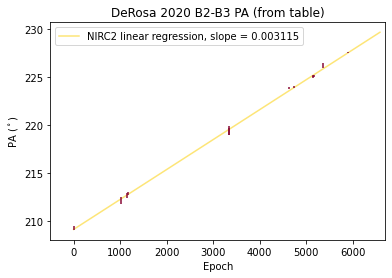

In [10]:
# DeRosa result
slope, intercept, r_value, p_value, std_err = stats.linregress(results['epoch'][0:10], results['true pa'][0:10])
plt.errorbar(results['epoch'], results['true pa'], yerr=results['true pa err'], color='#870734', ls='none', zorder=1)
label = "NIRC2 linear regression, slope = "+str(round(slope,6))
plt.plot(results['epoch'], intercept + slope*results['epoch'], color='#fde577', label=label, zorder=0)
plt.legend()
plt.xlim(-500, 6700)
plt.title('DeRosa 2020 B2-B3 PA (from table)')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
plt.savefig('derosa_pa.png', dpq=200)

<ipython-input-11-93149d8b3c8f>:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpq" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('balmer_pa.png', dpq=200)


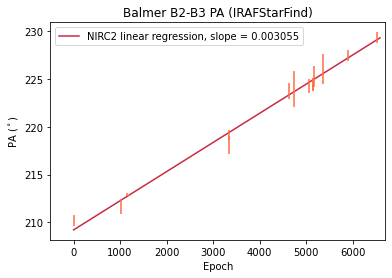

In [11]:
# my result
slope, intercept, r_value, p_value, std_err = stats.linregress(results['epoch'], results['PA'])
plt.errorbar(results['epoch'], results['PA'], yerr=results['PAerr'], ls='none', color='#ff6c40', zorder=1)
label = "NIRC2 linear regression, slope = "+str(round(slope,6))
plt.plot(results['epoch'], intercept + slope*results['epoch'], color='#c72a40', label=label, zorder=0)
plt.legend()
plt.xlim(-500, 6700)
plt.title('Balmer B2-B3 PA (IRAFStarFind)')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
plt.savefig('balmer_pa.png', dpq=200)

<ipython-input-10-75f4e2d607bc>:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpq" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('pa_compare.png', dpq=200)


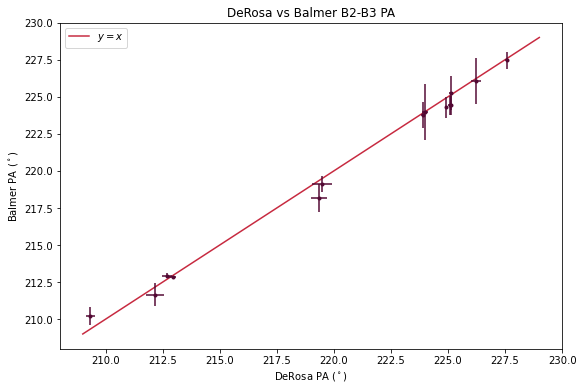

In [10]:
plt.figure(figsize=(9,6))
plt.errorbar(x=results['true pa'], y=results['PA'], xerr=results['true pa err'], yerr=results['PAerr'], ls='none', zorder=1, marker='o', color='#520833', markersize=3)
plt.plot([209,229],[209,229], label=r'$y=x$', zorder=0, color='#c72a40')
plt.title('DeRosa vs Balmer B2-B3 PA')
plt.legend()
plt.xlabel(r'DeRosa PA ($^\circ$)')
plt.ylabel(r'Balmer PA ($^\circ$)')
plt.savefig('pa_compare.png', dpq=200)

<ipython-input-19-3794c847e5c0>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpq" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('derosa_sep.png', dpq=200)


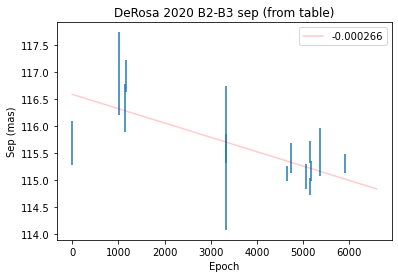

In [19]:
# DeRosa result for sep
slope, intercept, r_value, p_value, std_err = stats.linregress(results['epoch'][0:10], results['true sep'][0:10])
plt.errorbar(results['epoch'], results['true sep'], yerr=results['true sep err'], ls='none')
plt.plot(results['epoch'], intercept + slope*results['epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
# plt.xlim(-500, 6700)
plt.title('DeRosa 2020 B2-B3 sep (from table)')
plt.xlabel('Epoch')
plt.ylabel('Sep (mas)')
# plt.savefig('derosa_sep.png', dpq=200)

<ipython-input-20-f044188cd82b>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpq" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('balmer_sep.png', dpq=200)


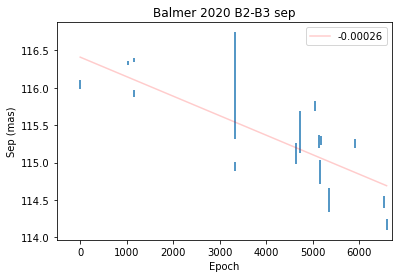

In [20]:
# my result
slope, intercept, r_value, p_value, std_err = stats.linregress(results['epoch'], results['sep'])
plt.errorbar(results['epoch'], results['sep'], yerr=results['seperr'], ls='none')
plt.plot(results['epoch'], intercept + slope*results['epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
plt.xlim(-500, 6700)
plt.title('Balmer 2020 B2-B3 sep')
plt.xlabel('Epoch')
plt.ylabel('Sep (mas)')
# plt.savefig('balmer_sep.png', dpq=200)

<ipython-input-19-a493ed3652a7>:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpq" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('sep_compare.png', dpq=200)


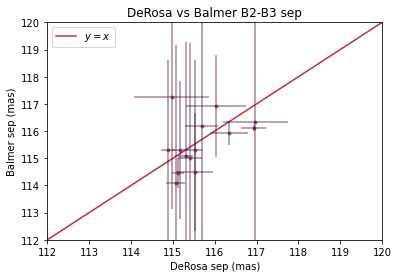

In [19]:
plt.errorbar(x=results3['tsep'], y=results3['sep'], xerr=results3['tseperr'], yerr=results3['seperr'], ls='none', zorder=1, marker='o', color='#520833', markersize=3, alpha=0.5)
plt.plot([112,120],[112,120], label=r'$y=x$', zorder=0, color='#c72a40')
plt.xlim(112,120)
plt.ylim(112,120)
plt.title('DeRosa vs Balmer B2-B3 sep')
plt.legend()
plt.xlabel('DeRosa sep (mas)')
plt.ylabel('Balmer sep (mas)')
plt.savefig('sep_compare.png', dpq=200)

rotations for stamps:
0 -> none
1 -> 90 deg counterclockwise
2 -> none
3 -> none
4 -> none
5 -> weird
6 -> weird
7 -> weird
8 -> none
9 -> none
10 -> weird
11 -> none
12 -> none
13 -> none
14 -> none
15 -> none

In [3]:
import numpy as np
from astropy.io import fits
import glob
import datetime
import matplotlib.pyplot as plt  
from matplotlib.animation import FuncAnimation, PillowWriter
from photutils import CircularAperture
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=AsinhStretch())

In [4]:
imlist = glob.glob('b2b3stamps/*.fits')
len(imlist)

8

In [5]:
imdatedict = {}
imdates = []
for im in imlist:
    imdata, imhead = fits.getdata(im, header=True)
    imdata = imdata[0]
    date = imhead['DATE-OBS']
    date_time_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datestr = date_time_obj.strftime("%Y-%m-%d")
    imdatedict[datestr] = imdata
    imdates.append(datestr)

imdates.sort(key=lambda date: datetime.datetime.strptime(date, "%Y-%m-%d"))

In [6]:
imcube = np.zeros((len(imlist),75,75))
i = 0
for date in imdates:
    imcube[i] = imdatedict[date]
    i += 1

In [7]:
lims = []
for im in imcube:
    mi = im.min()
    ma = im.max()
    lims.append([mi,ma])

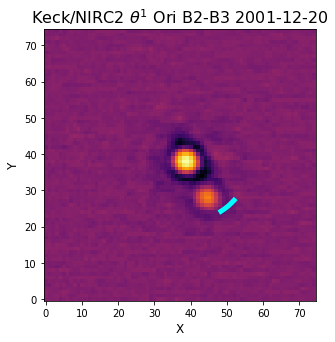

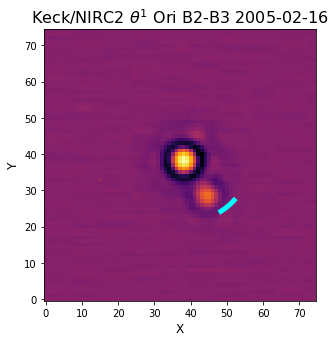

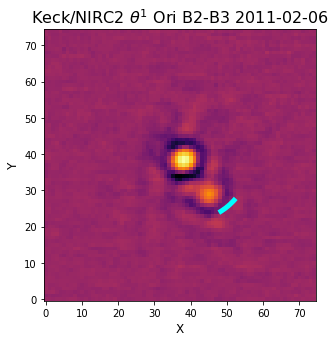

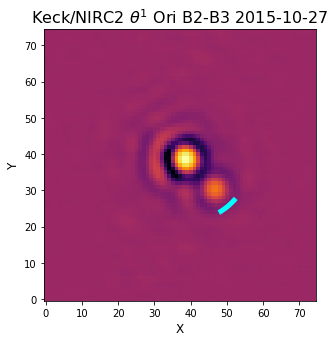

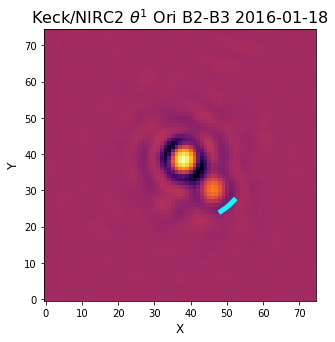

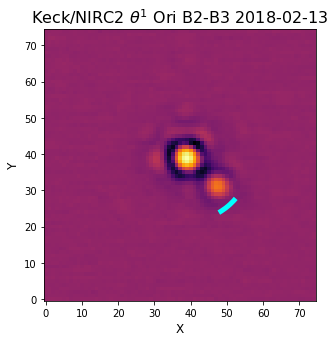

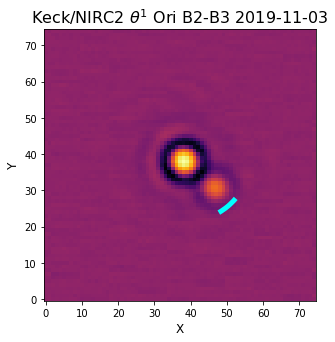

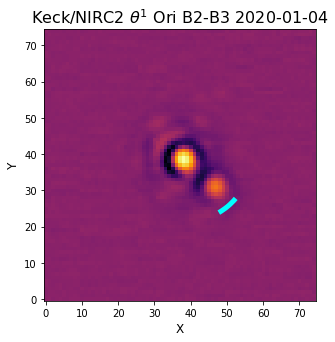

In [33]:
import matplotlib
import imageio
from matplotlib.patches import Arc

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def plot_for_offset(i):
    fig, ax = plt.subplots(figsize=(5,5))
    fig.patch.set_alpha(0)
    ax.imshow(imcube[i], origin='lower', norm=ImageNormalize(imcube[i], stretch=AsinhStretch()), cmap='inferno')
    ax.plot()
    ax.set(xlabel='X', ylabel='Y',
           title=r'Keck/NIRC2 $\theta^1$ Ori B2-B3 {}'.format(imdates[i]))
    e1 = Arc((39,39), 35, 35, angle=0.0, theta1=300, theta2=320, lw=5, color='cyan')
    ax.add_patch(e1)
    
    # IMPORTANT ANIMATION CODE HERE
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./orbit.gif', [plot_for_offset(i) for i in range(len(imdates))], fps=1)

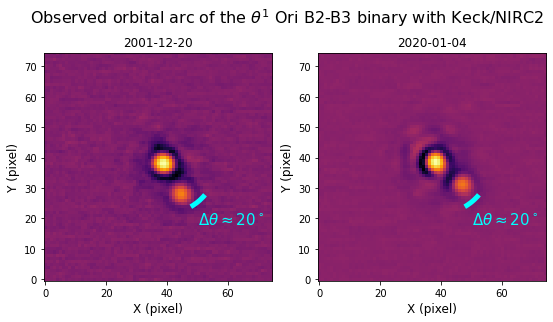

In [58]:
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
fig = plt.figure(figsize=(9,9))
ax_dict = fig.subplot_mosaic(
    [['first',  'last']])
i = 7
for frame in ax_dict:
    ax = ax_dict[frame]
    ax.imshow(imcube[i], origin='lower', norm=ImageNormalize(imcube[i], stretch=AsinhStretch()), cmap='inferno')
    ax.plot()
    ax.set(xlabel='X (pixel)', ylabel='Y (pixel)',
           title='{}'.format(imdates[i]))
    e1 = Arc((39,39), 35, 35, angle=0.0, theta1=300, theta2=320, lw=5, color='cyan')
    ax.add_patch(e1)
    ax.annotate(xy=[50,18], s=r'$\Delta\theta \approx 20^\circ$', c='cyan', size=15, weight='bold')
    i -= 7
fig.suptitle(r'Observed orbital arc of the $\theta^1$ Ori B2-B3 binary with Keck/NIRC2', y=0.75)
plt.savefig('b2b3_motion_figure.png', dpi=300)